In [19]:
import statsmodels
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotnine as p
from matplotlib.pyplot import figure
import plotnine as p
from plotnine.data import diamonds
import anndata
from patsy import dmatrices

import statsmodels.formula.api as smf

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
#load the adata with only 400 highly variable genes, so that it uses less memory 
adata=anndata.read_h5ad('400hvg_ren2021.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 1462702 × 400
    obs: 'patient', 'batch', 'city', 'age', 'sex', 'sample_type', 'severity', 'sample_point', 'sample_day', 'infected', 'platform', 'BCR', 'TCR', 'outcome', 'comorbidities', 'medication', 'leukocytes', 'neutrophils', 'Mean Genes', 'Mean UMI', 'cell_type'
    var: 'highly_variable', 'observed_fraction_zeros', 'expected_fraction_zeros', 'prob_zero_enriched_nbatches', 'prob_zero_enrichment', 'prob_zero_enrichment_rank'
    uns: 'hvg'

In [4]:
# convert gene count matrix to dense array because statsmodels only works on dense matrices
df = pd.DataFrame(adata.X.todense())
df

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,6.0,19.0,10.0,5.0,7.0,37.0,7.0,1.0,3.0,11.0,...,5.0,14.0,6.0,3.0,18.0,0.0,3.0,4.0,6.0,3.0
1,2.0,0.0,0.0,0.0,1.0,1.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0
2,9.0,10.0,2.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,...,0.0,0.0,2.0,1.0,2.0,4.0,5.0,12.0,20.0,0.0
3,11.0,3.0,9.0,9.0,4.0,65.0,1.0,0.0,0.0,5.0,...,1.0,15.0,8.0,5.0,3.0,0.0,0.0,23.0,8.0,2.0
4,11.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,16.0,0.0,7.0,1.0,12.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1462697,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,2.0,1.0,0.0,0.0
1462698,1.0,0.0,2.0,0.0,2.0,0.0,0.0,4.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1462699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1462700,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0


In [5]:
newcols = [ 'g'+str(col) for col in df.columns]
df.columns=newcols

In [6]:
obs=pd.read_csv('obs_wrangled_ren2021.csv', index_col=0)
obs['age']=obs['agestr']
obs

/home/edaveiga/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.


,patient,batch,city,sex,sample_type,severity,sample_point,sample_day,infected,outcome,cell_type,patient_num,agestr,age_untied,patunique,patnum,agerank,age
d01_sample_A_AACAGGGGTCGGATTT,P-S070,Batch01,Zhuhai,F,frozen PBMC,severe/critical,progression,7,positive,discharged,Mono,173,32,32.0174,P-S070-F32-s,174,37,32
d01_sample_A_AACCAACGTCCGAAAG,P-S070,Batch01,Zhuhai,F,frozen PBMC,severe/critical,progression,7,positive,discharged,B,173,32,32.0174,P-S070-F32-s,174,37,32
d01_sample_A_AACCTTTGTAGCACGA,P-S070,Batch01,Zhuhai,F,frozen PBMC,severe/critical,progression,7,positive,discharged,B,173,32,32.0174,P-S070-F32-s,174,37,32
d01_sample_A_AAGCATCTCTATCGCC,P-S070,Batch01,Zhuhai,F,frozen PBMC,severe/critical,progression,7,positive,discharged,Mono,173,32,32.0174,P-S070-F32-s,174,37,32
d01_sample_A_AATCACGGTCATAAAG,P-S070,Batch01,Zhuhai,F,frozen PBMC,severe/critical,progression,7,positive,discharged,B,173,32,32.0174,P-S070-F32-s,174,37,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d17_9_TTTGTCATCCACGCAG,P-S053,Batch17,Beijing,F,frozen PBMC,severe/critical,progression,9,positive,discharged,Mega,156,46,46.0157,P-S053-F46-s,157,86,46
d17_9_TTTGTCATCCGCTGTT,P-S053,Batch17,Beijing,F,frozen PBMC,severe/critical,progression,9,positive,discharged,Plasma,156,46,46.0157,P-S053-F46-s,157,86,46
d17_9_TTTGTCATCGTCGTTC,P-S053,Batch17,Beijing,F,frozen PBMC,severe/critical,progression,9,positive,discharged,CD8,156,46,46.0157,P-S053-F46-s,157,86,46
d17_9_TTTGTCATCTGTACGA,P-S053,Batch17,Beijing,F,frozen PBMC,severe/critical,progression,9,positive,discharged,NK,156,46,46.0157,P-S053-F46-s,157,86,46


In [7]:
df.index=obs.index
for col in obs.columns:
    df[col]=obs[col]
df

,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,...,infected,outcome,cell_type,patient_num,agestr,age_untied,patunique,patnum,agerank,age
d01_sample_A_AACAGGGGTCGGATTT,6.0,19.0,10.0,5.0,7.0,37.0,7.0,1.0,3.0,11.0,...,positive,discharged,Mono,173,32,32.0174,P-S070-F32-s,174,37,32
d01_sample_A_AACCAACGTCCGAAAG,2.0,0.0,0.0,0.0,1.0,1.0,4.0,0.0,0.0,0.0,...,positive,discharged,B,173,32,32.0174,P-S070-F32-s,174,37,32
d01_sample_A_AACCTTTGTAGCACGA,9.0,10.0,2.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,...,positive,discharged,B,173,32,32.0174,P-S070-F32-s,174,37,32
d01_sample_A_AAGCATCTCTATCGCC,11.0,3.0,9.0,9.0,4.0,65.0,1.0,0.0,0.0,5.0,...,positive,discharged,Mono,173,32,32.0174,P-S070-F32-s,174,37,32
d01_sample_A_AATCACGGTCATAAAG,11.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,positive,discharged,B,173,32,32.0174,P-S070-F32-s,174,37,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d17_9_TTTGTCATCCACGCAG,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,positive,discharged,Mega,156,46,46.0157,P-S053-F46-s,157,86,46
d17_9_TTTGTCATCCGCTGTT,1.0,0.0,2.0,0.0,2.0,0.0,0.0,4.0,0.0,0.0,...,positive,discharged,Plasma,156,46,46.0157,P-S053-F46-s,157,86,46
d17_9_TTTGTCATCGTCGTTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,positive,discharged,CD8,156,46,46.0157,P-S053-F46-s,157,86,46
d17_9_TTTGTCATCTGTACGA,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,...,positive,discharged,NK,156,46,46.0157,P-S053-F46-s,157,86,46


In [8]:
### print a string that will be used to define the model corresponding to the 400 genes, 
# which as just numbers with g in frong to make them python valid variable names and avoid headaches

for g in newcols:
    print(g,end=' + ')

g0 + g1 + g2 + g3 + g4 + g5 + g6 + g7 + g8 + g9 + g10 + g11 + g12 + g13 + g14 + g15 + g16 + g17 + g18 + g19 + g20 + g21 + g22 + g23 + g24 + g25 + g26 + g27 + g28 + g29 + g30 + g31 + g32 + g33 + g34 + g35 + g36 + g37 + g38 + g39 + g40 + g41 + g42 + g43 + g44 + g45 + g46 + g47 + g48 + g49 + g50 + g51 + g52 + g53 + g54 + g55 + g56 + g57 + g58 + g59 + g60 + g61 + g62 + g63 + g64 + g65 + g66 + g67 + g68 + g69 + g70 + g71 + g72 + g73 + g74 + g75 + g76 + g77 + g78 + g79 + g80 + g81 + g82 + g83 + g84 + g85 + g86 + g87 + g88 + g89 + g90 + g91 + g92 + g93 + g94 + g95 + g96 + g97 + g98 + g99 + g100 + g101 + g102 + g103 + g104 + g105 + g106 + g107 + g108 + g109 + g110 + g111 + g112 + g113 + g114 + g115 + g116 + g117 + g118 + g119 + g120 + g121 + g122 + g123 + g124 + g125 + g126 + g127 + g128 + g129 + g130 + g131 + g132 + g133 + g134 + g135 + g136 + g137 + g138 + g139 + g140 + g141 + g142 + g143 + g144 + g145 + g146 + g147 + g148 + g149 + g150 + g151 + g152 + g153 + g154 + g155 + g156 + g157 + g158

In [9]:
# poisson regression, based on this tutorial: 
# https://towardsdatascience.com/negative-binomial-regression-f99031bb25b4



#Setup the regression expression in patsy notation. We are telling patsy that age is our dependent variable and it depends on the regression variables: g0 ...g399
expr = """age ~ g0 + g1 + g2 + g3 + g4 + g5 + g6 + g7 + g8 + g9 + g10 + g11 + g12 + g13 + g14 + g15 + g16 + g17 + g18 + g19 + g20 + g21 + g22 + g23 + g24 + g25 + g26 + g27 + g28 + g29 + g30 + g31 + g32 + g33 + g34 + g35 + g36 + g37 + g38 + g39 + g40 + g41 + g42 + g43 + g44 + g45 + g46 + g47 + g48 + g49 + g50 + g51 + g52 + g53 + g54 + g55 + g56 + g57 + g58 + g59 + g60 + g61 + g62 + g63 + g64 + g65 + g66 + g67 + g68 + g69 + g70 + g71 + g72 + g73 + g74 + g75 + g76 + g77 + g78 + g79 + g80 + g81 + g82 + g83 + g84 + g85 + g86 + g87 + g88 + g89 + g90 + g91 + g92 + g93 + g94 + g95 + g96 + g97 + g98 + g99 + g100 + g101 + g102 + g103 + g104 + g105 + g106 + g107 + g108 + g109 + g110 + g111 + g112 + g113 + g114 + g115 + g116 + g117 + g118 + g119 + g120 + g121 + g122 + g123 + g124 + g125 + g126 + g127 + g128 + g129 + g130 + g131 + g132 + g133 + g134 + g135 + g136 + g137 + g138 + g139 + g140 + g141 + g142 + g143 + g144 + g145 + g146 + g147 + g148 + g149 + g150 + g151 + g152 + g153 + g154 + g155 + g156 + g157 + g158 + g159 + g160 + g161 + g162 + g163 + g164 + g165 + g166 + g167 + g168 + g169 + g170 + g171 + g172 + g173 + g174 + g175 + g176 + g177 + g178 + g179 + g180 + g181 + g182 + g183 + g184 + g185 + g186 + g187 + g188 + g189 + g190 + g191 + g192 + g193 + g194 + g195 + g196 + g197 + g198 + g199 + g200 + g201 + g202 + g203 + g204 + g205 + g206 + g207 + g208 + g209 + g210 + g211 + g212 + g213 + g214 + g215 + g216 + g217 + g218 + g219 + g220 + g221 + g222 + g223 + g224 + g225 + g226 + g227 + g228 + g229 + g230 + g231 + g232 + g233 + g234 + g235 + g236 + g237 + g238 + g239 + g240 + g241 + g242 + g243 + g244 + g245 + g246 + g247 + g248 + g249 + g250 + g251 + g252 + g253 + g254 + g255 + g256 + g257 + g258 + g259 + g260 + g261 + g262 + g263 + g264 + g265 + g266 + g267 + g268 + g269 + g270 + g271 + g272 + g273 + g274 + g275 + g276 + g277 + g278 + g279 + g280 + g281 + g282 + g283 + g284 + g285 + g286 + g287 + g288 + g289 + g290 + g291 + g292 + g293 + g294 + g295 + g296 + g297 + g298 + g299 + g300 + g301 + g302 + g303 + g304 + g305 + g306 + g307 + g308 + g309 + g310 + g311 + g312 + g313 + g314 + g315 + g316 + g317 + g318 + g319 + g320 + g321 + g322 + g323 + g324 + g325 + g326 + g327 + g328 + g329 + g330 + g331 + g332 + g333 + g334 + g335 + g336 + g337 + g338 + g339 + g340 + g341 + g342 + g343 + g344 + g345 + g346 + g347 + g348 + g349 + g350 + g351 + g352 + g353 + g354 + g355 + g356 + g357 + g358 + g359 + g360 + g361 + g362 + g363 + g364 + g365 + g366 + g367 + g368 + g369 + g370 + g371 + g372 + g373 + g374 + g375 + g376 + g377 + g378 + g379 + g380 + g381 + g382 + g383 + g384 + g385 + g386 + g387 + g388 + g389 + g390 + g391 + g392 + g393 + g394 + g395 + g396 + g397 + g398 + g399"""

#Set up the X and y matrices for the training and testing data sets
y_train, X_train = dmatrices(expr, df, return_type='dataframe')
y_test, X_test = dmatrices(expr, df, return_type='dataframe')

#Using the statsmodels GLM class, train the Poisson regression model on the training data set
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

#print out the training summary
print(poisson_training_results.summary())

#print out the fitted rate vector
print(poisson_training_results.mu)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    age   No. Observations:              1462702
Model:                            GLM   Df Residuals:                  1462301
Model Family:                 Poisson   Df Model:                          400
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -8.3975e+06
Date:                Mon, 05 Jul 2021   Deviance:                   8.5787e+06
Time:                        00:37:51   Pearson chi2:                 7.87e+06
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8762      0.000   1.45e+04      0.0

In [10]:
# define plotting function, stratify groups by sex and condition (severe/mild/controls)
def ageplot(df=df, alpha=0.1, title=' Age plot', size=(20,7),dpi=120):
    fig=plt.figure(figsize=size, dpi=dpi)
    
    ax = plt.gca()
    colorslist = ['forestgreen','darkblue','blue','yellowgreen','cyan','lime','red','purple','pink','orange']
    dfages = df[['agerank', 'age']].drop_duplicates()
    colorcounter=0
    describe_full=df[['patnum','pred_ages']].groupby('patnum').describe()['pred_ages']
    for condition in df.conditions.unique():
        color=colorslist[colorcounter]
        ddf=df[df['conditions']==condition]
        describe = describe_full[describe_full.index.isin(ddf.patnum)]
#         ax.scatter(ddf['agerank'], ddf['pred_ages'],  alpha = alpha, s = 10, label=condition, edgecolors='none', color=color)
        ax.scatter(describe.index,describe['mean'], color=color, marker='.', label =  condition)
#         ax.scatter(describe.index,describe['25%'], color=color, marker='^',  s=3)
#         ax.scatter(describe.index,describe['75%'], color=color, marker='v',  s=3)
        for idx, row in describe.iterrows():
            ax.vlines(x=idx , ymin=row['25%'], ymax=row['75%'], color=color)
#             print(idx)
#             print(row)
        colorcounter+=1
    ax.scatter(dfages['agerank'],dfages['age'], color='k', marker='_', label = 'True age')

    
    ax.set_xlim((1,220))
    ax.set_ylim((0,100))
    ax.set_ylabel('Age')
    ax.set_ylabel('Patients ranked by age')
    ax.axes.xaxis.set_visible(False)
    
    leg = plt.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    plt.grid('True', linestyle='--', linewidth=0.5)
    plt.title(title)
    plt.show()


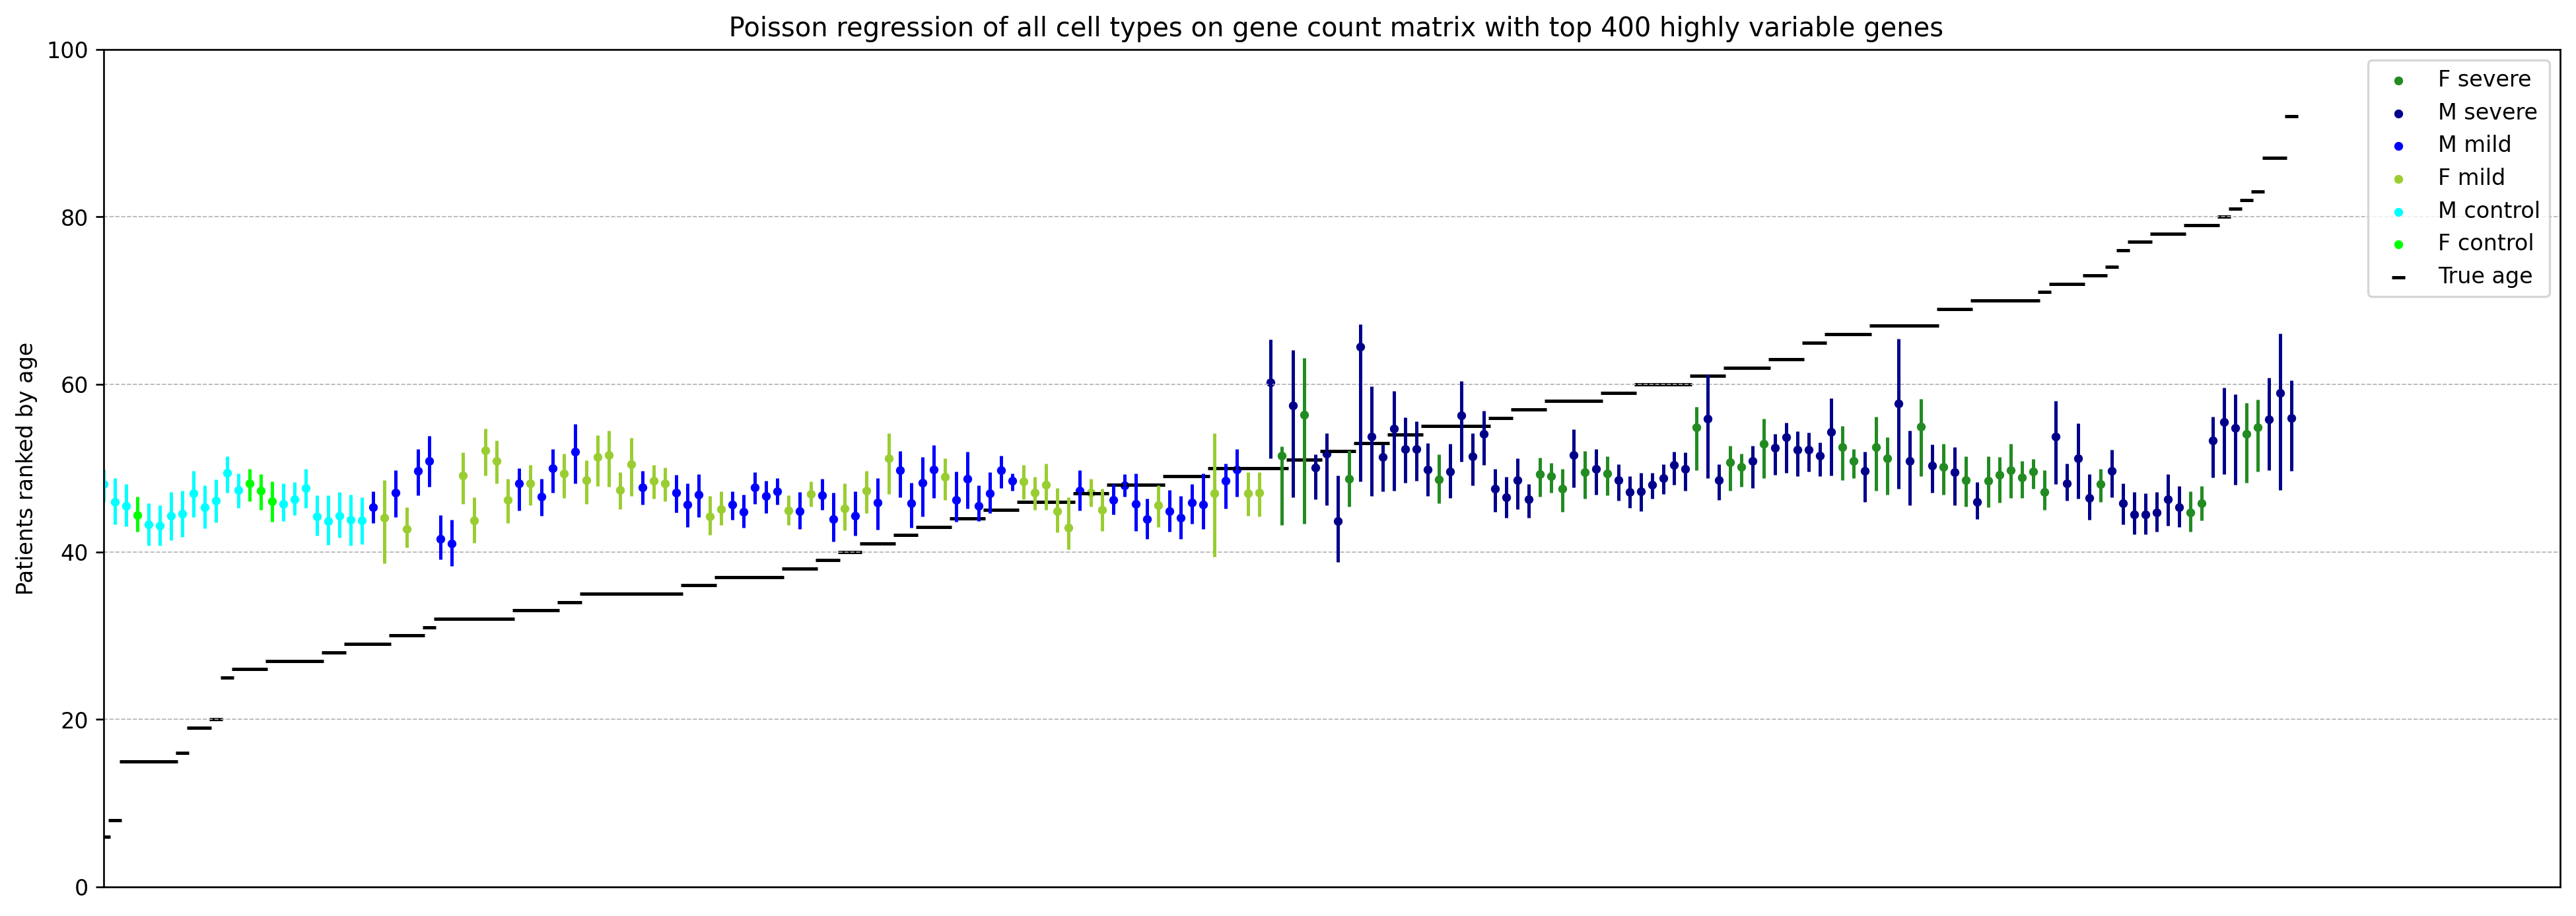

In [18]:
# predict the results of poisson regression and make plot
pred_obs=obs.copy()
pred_obs['pred_ages']= poisson_training_results.predict(X_train)

pred_obs.sex=df.sex.map({'M':'M','F':'F','unknown':'M'})
pred_obs['conditions']=pred_obs['sex']+' '+ pred_obs['severity'].str.split('/', expand=True)[0]
pred_obs['real_ages']=pred_obs['age']
ageplot(df=pred_obs, alpha=0.1, title=' Poisson regression of all cell types on gene count matrix with top 400 highly variable genes', size=(20,7),dpi=120)

In [ ]:
# negative binomial regression, based on this tutorial: 
# https://towardsdatascience.com/negative-binomial-regression-f99031bb25b4



#Setup the regression expression in patsy notation. We are telling patsy that age is our dependent variable and it depends on the regression variables: g0 ...g399
expr = """age ~ g0 + g1 + g2 + g3 + g4 + g5 + g6 + g7 + g8 + g9 + g10 + g11 + g12 + g13 + g14 + g15 + g16 + g17 + g18 + g19 + g20 + g21 + g22 + g23 + g24 + g25 + g26 + g27 + g28 + g29 + g30 + g31 + g32 + g33 + g34 + g35 + g36 + g37 + g38 + g39 + g40 + g41 + g42 + g43 + g44 + g45 + g46 + g47 + g48 + g49 + g50 + g51 + g52 + g53 + g54 + g55 + g56 + g57 + g58 + g59 + g60 + g61 + g62 + g63 + g64 + g65 + g66 + g67 + g68 + g69 + g70 + g71 + g72 + g73 + g74 + g75 + g76 + g77 + g78 + g79 + g80 + g81 + g82 + g83 + g84 + g85 + g86 + g87 + g88 + g89 + g90 + g91 + g92 + g93 + g94 + g95 + g96 + g97 + g98 + g99 + g100 + g101 + g102 + g103 + g104 + g105 + g106 + g107 + g108 + g109 + g110 + g111 + g112 + g113 + g114 + g115 + g116 + g117 + g118 + g119 + g120 + g121 + g122 + g123 + g124 + g125 + g126 + g127 + g128 + g129 + g130 + g131 + g132 + g133 + g134 + g135 + g136 + g137 + g138 + g139 + g140 + g141 + g142 + g143 + g144 + g145 + g146 + g147 + g148 + g149 + g150 + g151 + g152 + g153 + g154 + g155 + g156 + g157 + g158 + g159 + g160 + g161 + g162 + g163 + g164 + g165 + g166 + g167 + g168 + g169 + g170 + g171 + g172 + g173 + g174 + g175 + g176 + g177 + g178 + g179 + g180 + g181 + g182 + g183 + g184 + g185 + g186 + g187 + g188 + g189 + g190 + g191 + g192 + g193 + g194 + g195 + g196 + g197 + g198 + g199 + g200 + g201 + g202 + g203 + g204 + g205 + g206 + g207 + g208 + g209 + g210 + g211 + g212 + g213 + g214 + g215 + g216 + g217 + g218 + g219 + g220 + g221 + g222 + g223 + g224 + g225 + g226 + g227 + g228 + g229 + g230 + g231 + g232 + g233 + g234 + g235 + g236 + g237 + g238 + g239 + g240 + g241 + g242 + g243 + g244 + g245 + g246 + g247 + g248 + g249 + g250 + g251 + g252 + g253 + g254 + g255 + g256 + g257 + g258 + g259 + g260 + g261 + g262 + g263 + g264 + g265 + g266 + g267 + g268 + g269 + g270 + g271 + g272 + g273 + g274 + g275 + g276 + g277 + g278 + g279 + g280 + g281 + g282 + g283 + g284 + g285 + g286 + g287 + g288 + g289 + g290 + g291 + g292 + g293 + g294 + g295 + g296 + g297 + g298 + g299 + g300 + g301 + g302 + g303 + g304 + g305 + g306 + g307 + g308 + g309 + g310 + g311 + g312 + g313 + g314 + g315 + g316 + g317 + g318 + g319 + g320 + g321 + g322 + g323 + g324 + g325 + g326 + g327 + g328 + g329 + g330 + g331 + g332 + g333 + g334 + g335 + g336 + g337 + g338 + g339 + g340 + g341 + g342 + g343 + g344 + g345 + g346 + g347 + g348 + g349 + g350 + g351 + g352 + g353 + g354 + g355 + g356 + g357 + g358 + g359 + g360 + g361 + g362 + g363 + g364 + g365 + g366 + g367 + g368 + g369 + g370 + g371 + g372 + g373 + g374 + g375 + g376 + g377 + g378 + g379 + g380 + g381 + g382 + g383 + g384 + g385 + g386 + g387 + g388 + g389 + g390 + g391 + g392 + g393 + g394 + g395 + g396 + g397 + g398 + g399"""

#Set up the X and y matrices for the training and testing data sets
y_train, X_train = dmatrices(expr, df, return_type='dataframe')
y_test, X_test = dmatrices(expr, df, return_type='dataframe')

#Using the statsmodels GLM class, train the Poisson regression model on the training data set
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

#print out the training summary
print(poisson_training_results.summary())

#print out the fitted rate vector

print(poisson_training_results.mu)

In [21]:
# fit parameters to find overdispersion
df_train=df.copy()
df_train['BB_LAMBDA'] = poisson_training_results.mu
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['age'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""
aux_olsr_results = smf.ols(ols_expr, df_train).fit()
print(aux_olsr_results.params)


BB_LAMBDA    0.087718
dtype: float64


In [22]:
aux_olsr_results.tvalues


BB_LAMBDA    631.737613
dtype: float64

In [23]:
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

In [24]:
nb2_predictions = nb2_training_results.get_prediction(X_train)


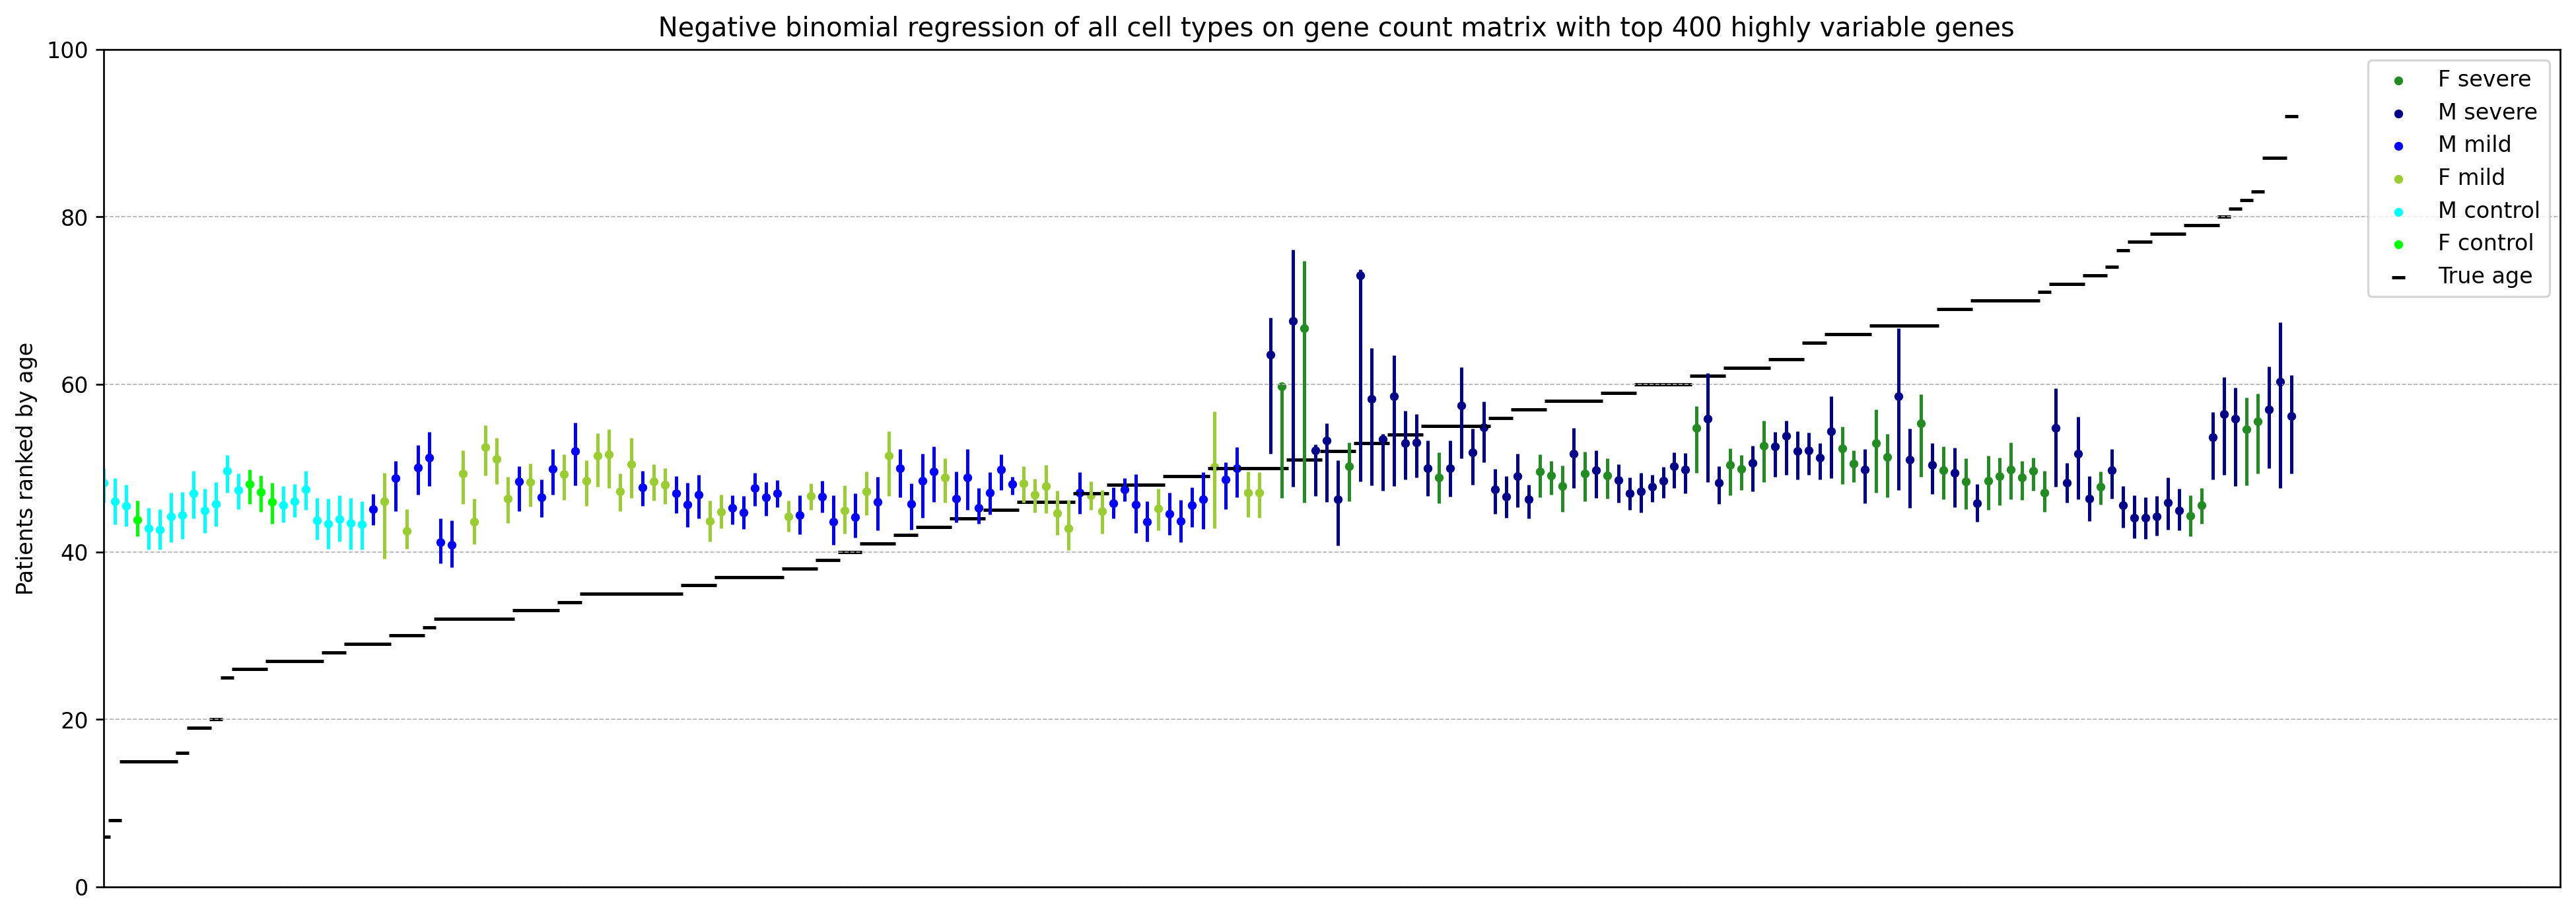

In [25]:
# predict the results of negative binomial regression and make plot
pred_obs=obs.copy()
pred_obs['pred_ages']= nb2_training_results.predict(X_train)

pred_obs.sex=df.sex.map({'M':'M','F':'F','unknown':'M'})
pred_obs['conditions']=pred_obs['sex']+' '+ pred_obs['severity'].str.split('/', expand=True)[0]
pred_obs['real_ages']=pred_obs['age']
ageplot(df=pred_obs, alpha=0.1, title=' Negative binomial regression of all cell types on gene count matrix with top 400 highly variable genes', size=(20,7),dpi=120)

# Poisson Regression statified per cell type 
The data contains the following cell types:
['Mono', 'B', 'Macro', 'CD4', 'CD8', 'NK', 'DC', 'Mega', 'Neu',
       'Plasma', 'Epi', 'Mast']
       
Can some of them make better predictors than others?

We try training the model on the matrix restricted to the relevant cell type

Doing regression for cell type... Mono
number of cells:  294788
number of patients:  196


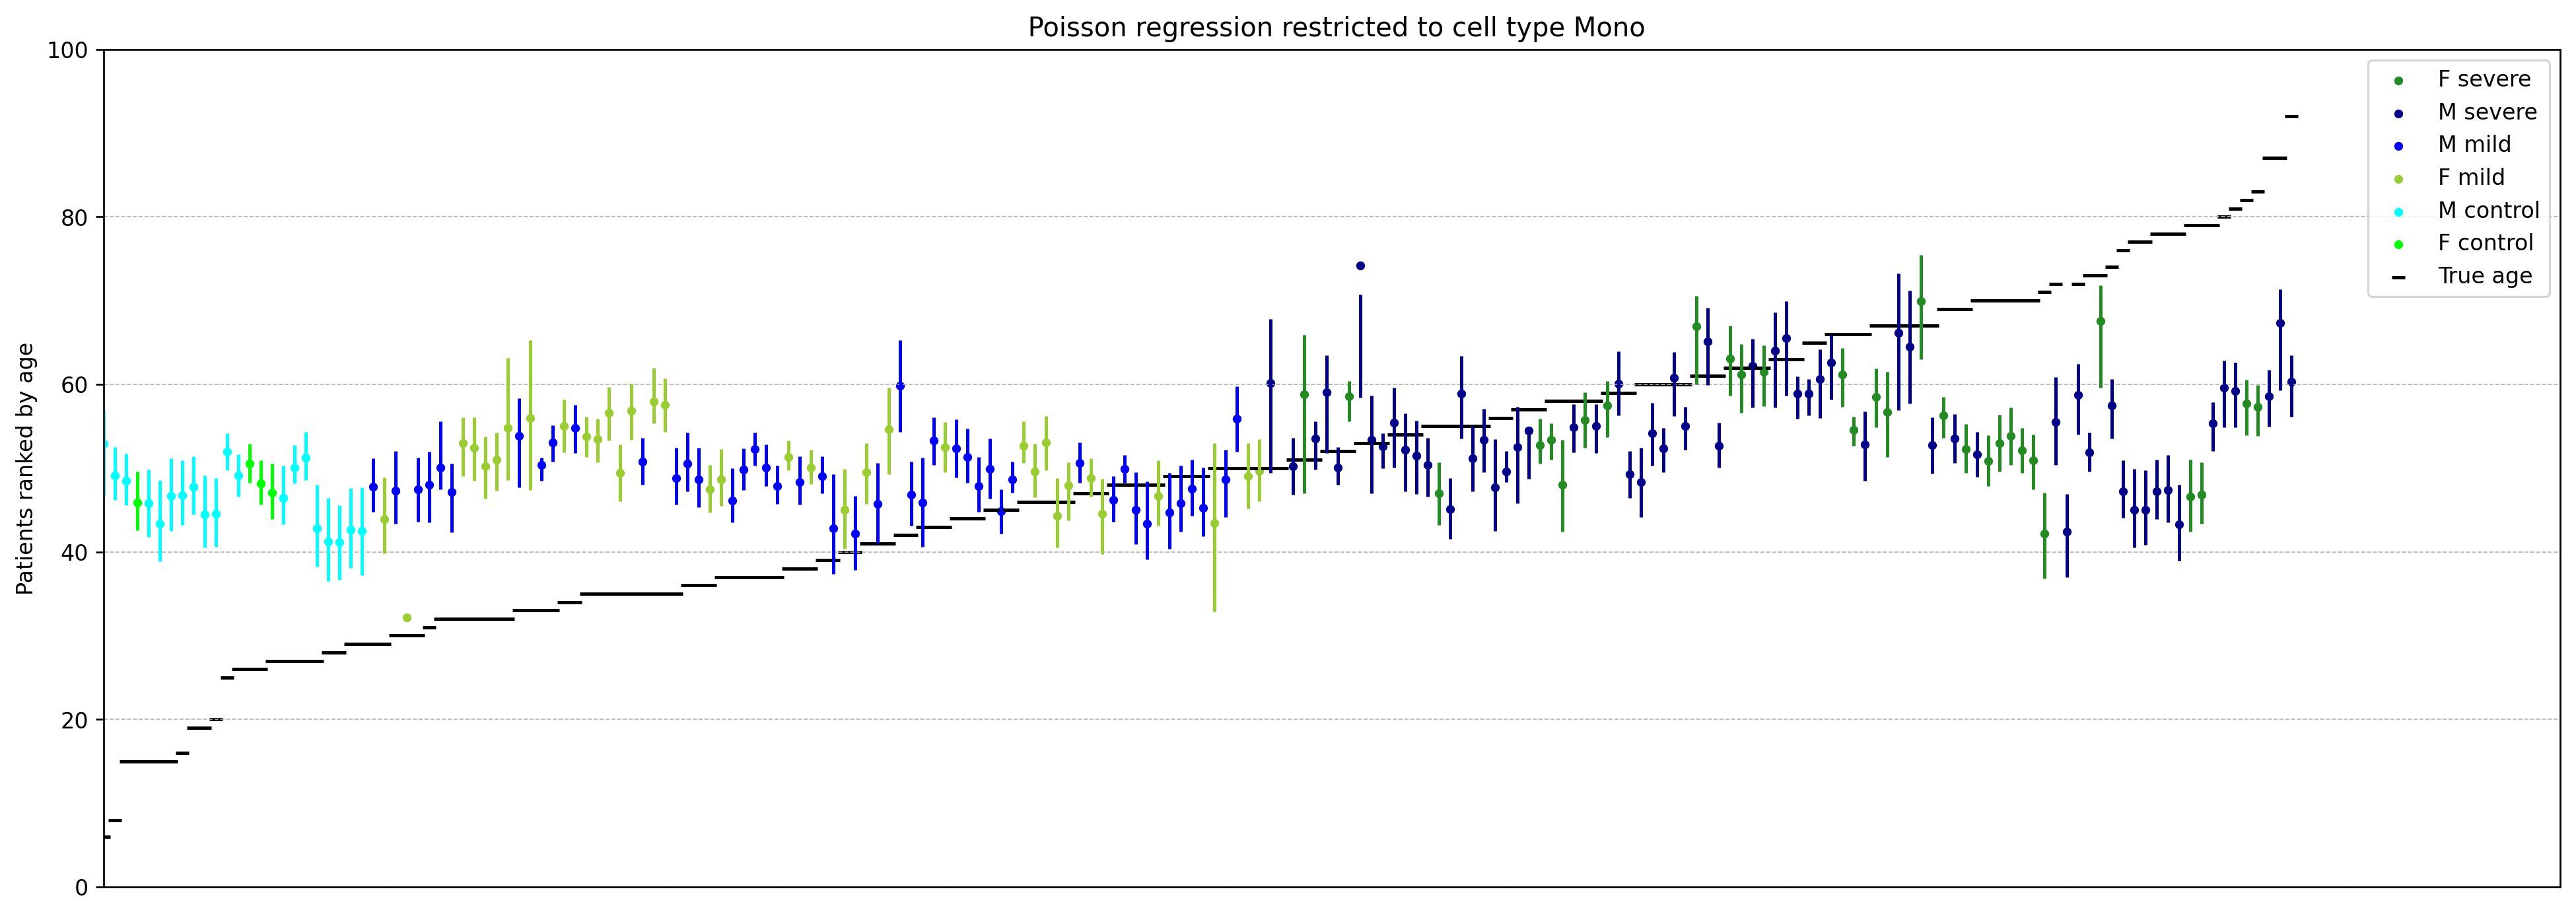

Doing regression for cell type... B
number of cells:  403700
number of patients:  197


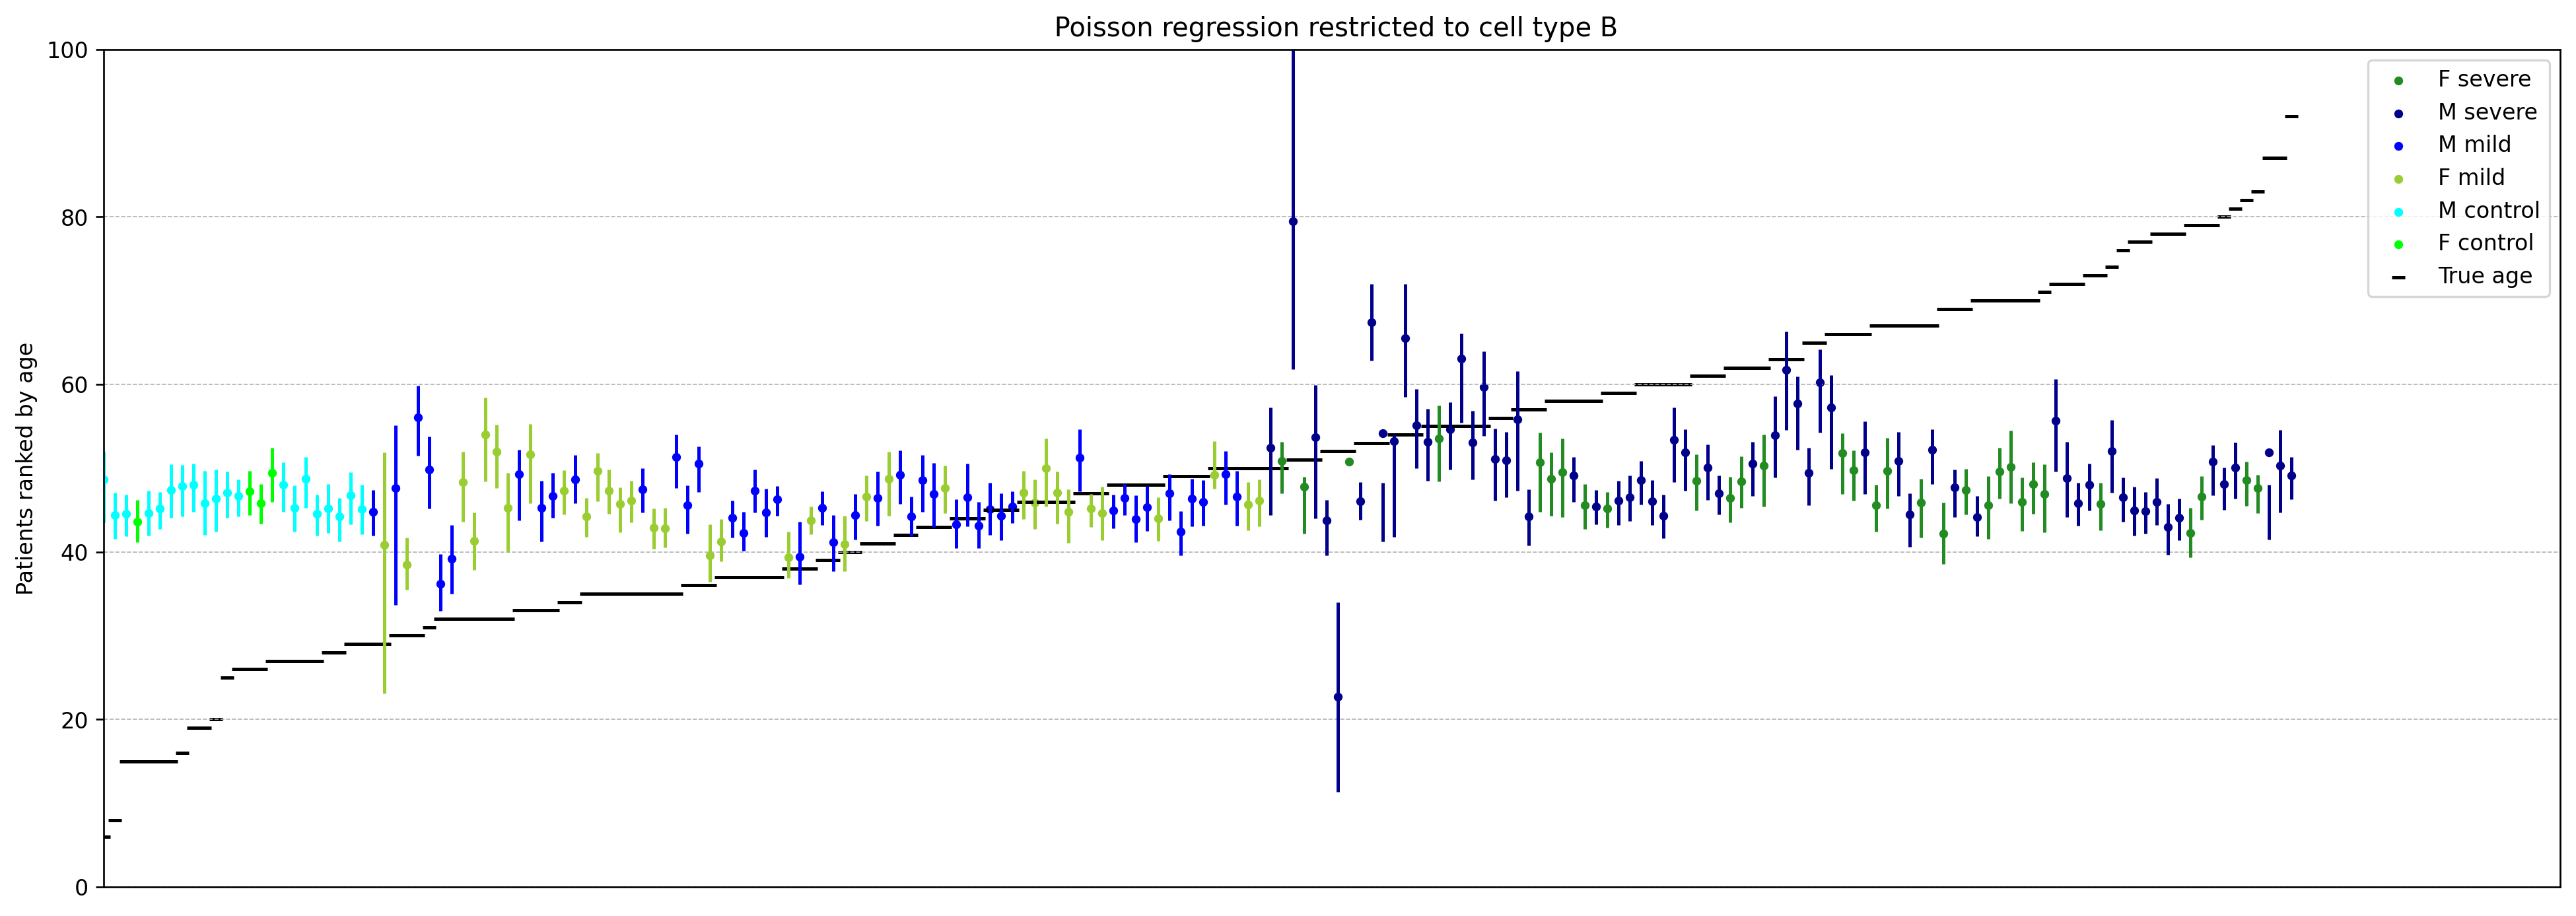

Doing regression for cell type... Macro
number of cells:  21471
number of patients:  124


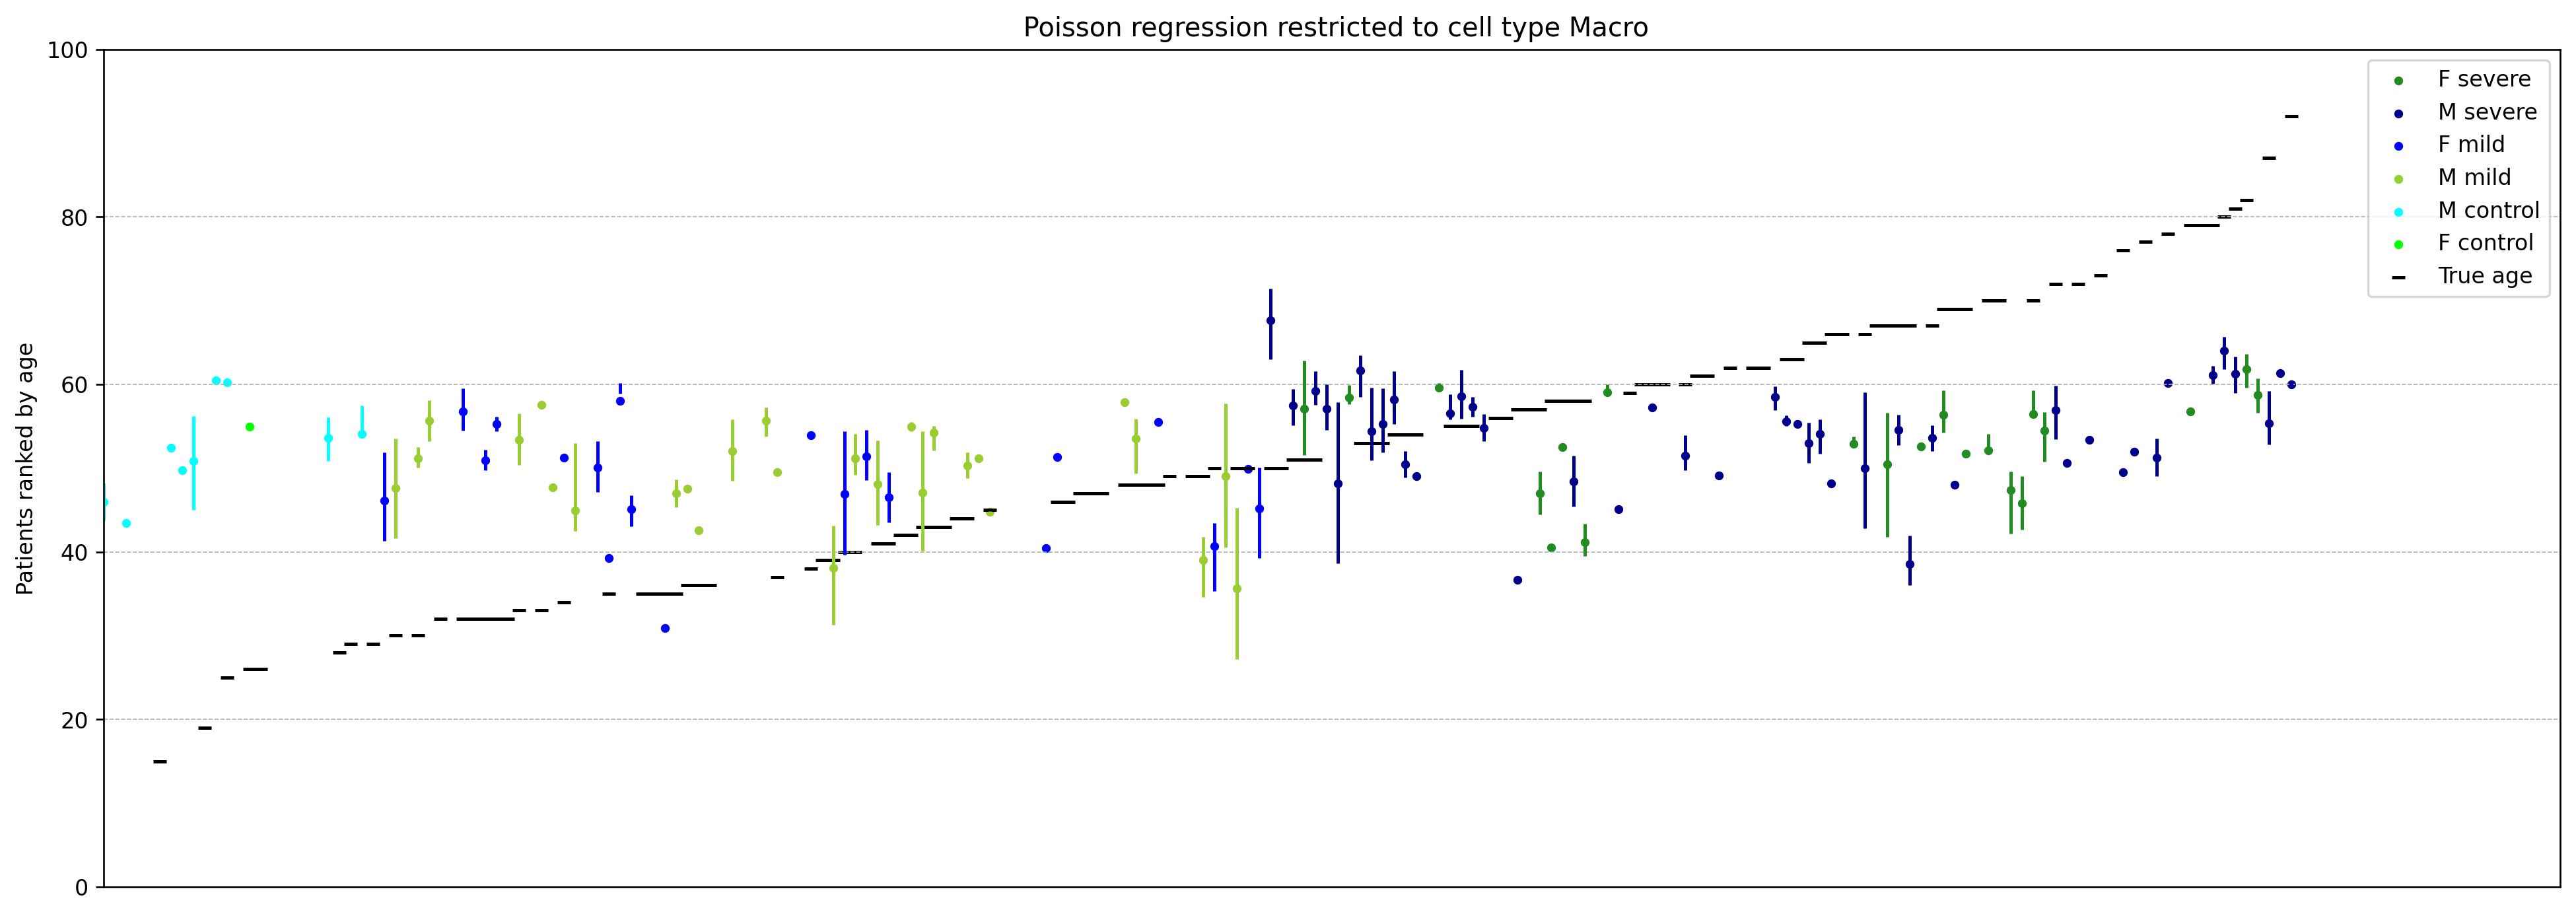

Doing regression for cell type... CD4
number of cells:  260141
number of patients:  196


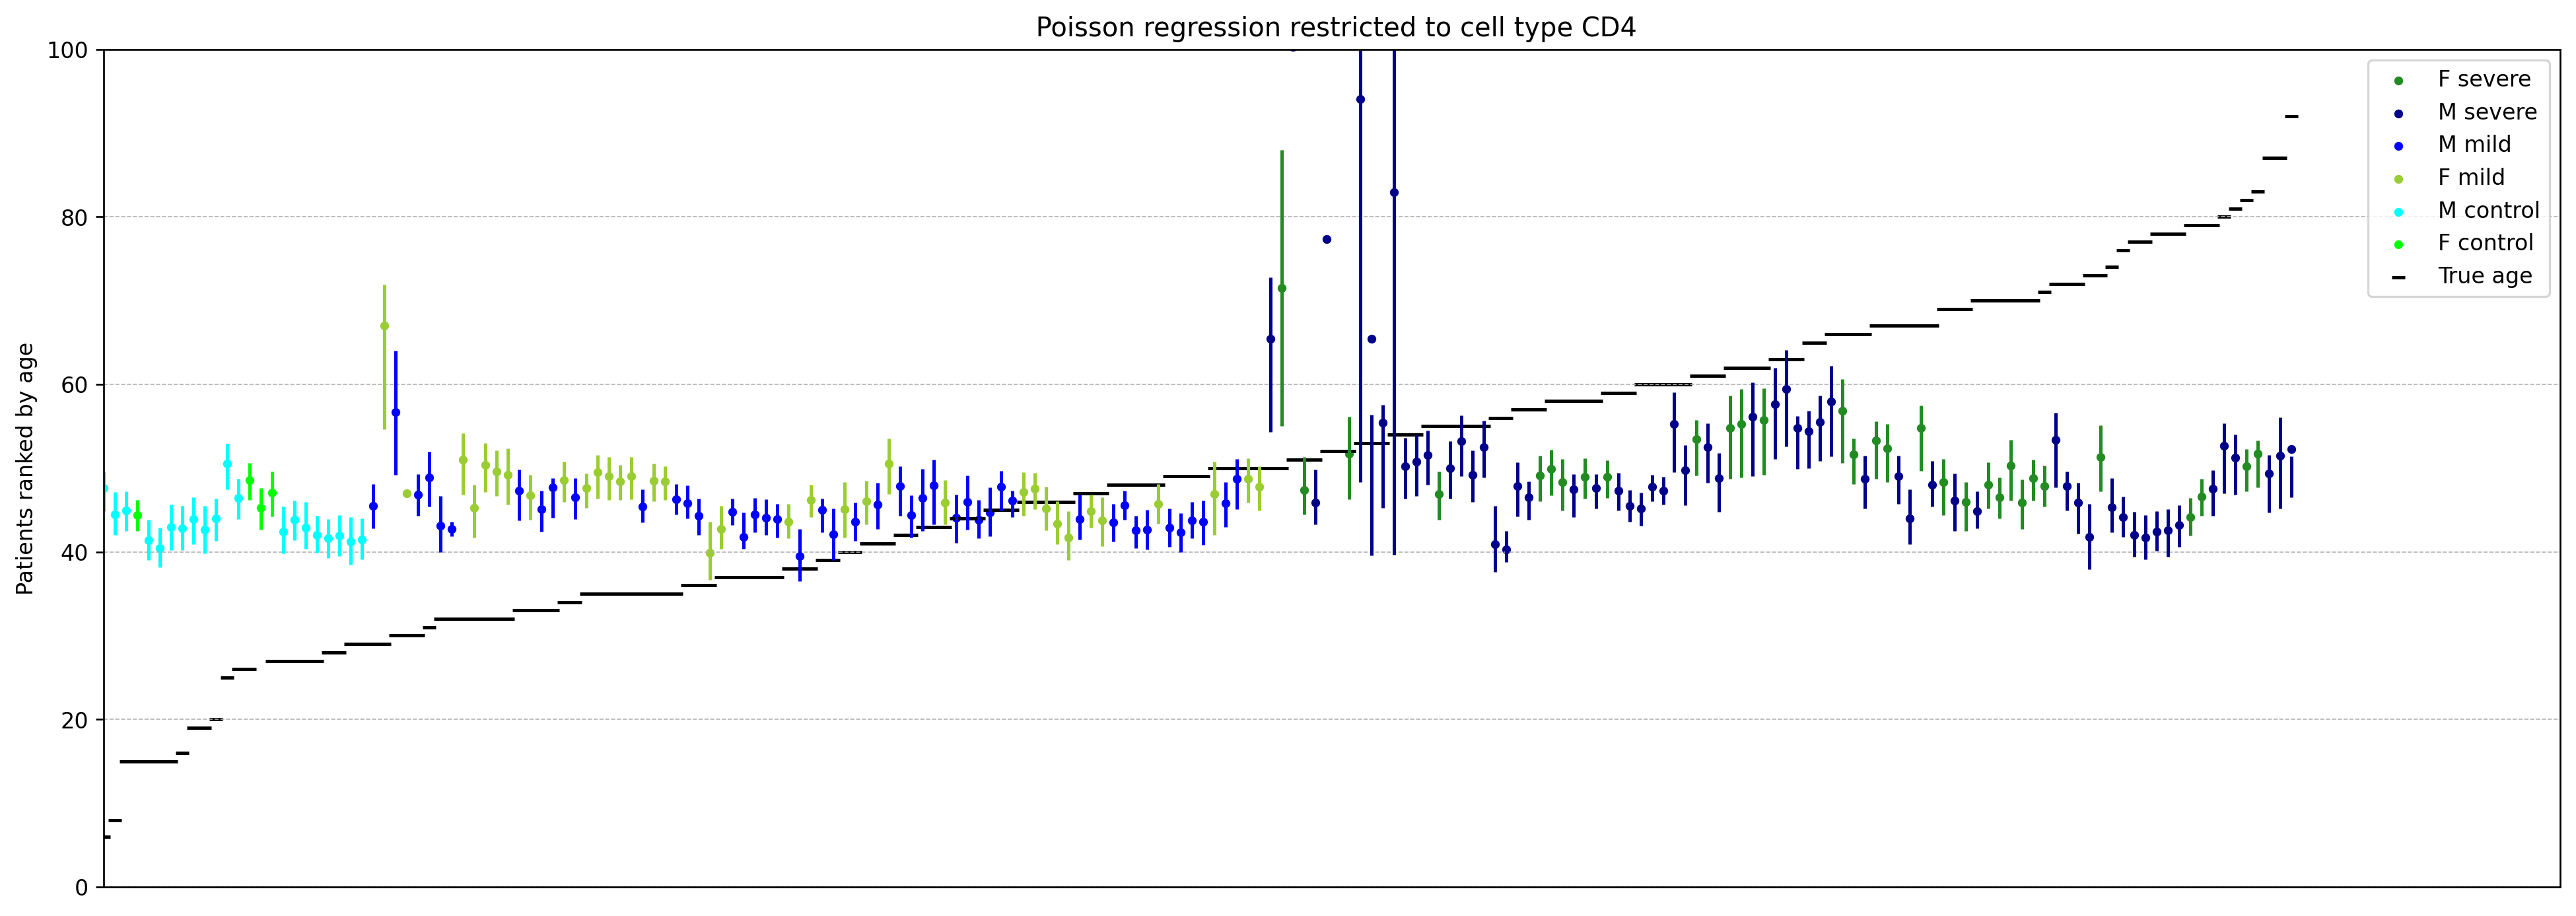

Doing regression for cell type... CD8
number of cells:  374454
number of patients:  197


In [ ]:
celltypes=obs.cell_type.unique()
for celltype in celltypes:
    print('Doing regression for cell type...', celltype)
    selection_array=obs.cell_type==celltype
    cell_type_obs=obs[selection_array].copy()
    cell_type_restricted_df=df[selection_array].copy()
    print('number of cells: ', cell_type_obs.shape[0])
    print('number of patients: ', len(cell_type_obs.patunique.unique()))

    #Setup the regression expression in patsy notation. We are telling patsy that age is our dependent variable and it depends on the regression variables: g0 ...g399
    expr = """age ~ g0 + g1 + g2 + g3 + g4 + g5 + g6 + g7 + g8 + g9 + g10 + g11 + g12 + g13 + g14 + g15 + g16 + g17 + g18 + g19 + g20 + g21 + g22 + g23 + g24 + g25 + g26 + g27 + g28 + g29 + g30 + g31 + g32 + g33 + g34 + g35 + g36 + g37 + g38 + g39 + g40 + g41 + g42 + g43 + g44 + g45 + g46 + g47 + g48 + g49 + g50 + g51 + g52 + g53 + g54 + g55 + g56 + g57 + g58 + g59 + g60 + g61 + g62 + g63 + g64 + g65 + g66 + g67 + g68 + g69 + g70 + g71 + g72 + g73 + g74 + g75 + g76 + g77 + g78 + g79 + g80 + g81 + g82 + g83 + g84 + g85 + g86 + g87 + g88 + g89 + g90 + g91 + g92 + g93 + g94 + g95 + g96 + g97 + g98 + g99 + g100 + g101 + g102 + g103 + g104 + g105 + g106 + g107 + g108 + g109 + g110 + g111 + g112 + g113 + g114 + g115 + g116 + g117 + g118 + g119 + g120 + g121 + g122 + g123 + g124 + g125 + g126 + g127 + g128 + g129 + g130 + g131 + g132 + g133 + g134 + g135 + g136 + g137 + g138 + g139 + g140 + g141 + g142 + g143 + g144 + g145 + g146 + g147 + g148 + g149 + g150 + g151 + g152 + g153 + g154 + g155 + g156 + g157 + g158 + g159 + g160 + g161 + g162 + g163 + g164 + g165 + g166 + g167 + g168 + g169 + g170 + g171 + g172 + g173 + g174 + g175 + g176 + g177 + g178 + g179 + g180 + g181 + g182 + g183 + g184 + g185 + g186 + g187 + g188 + g189 + g190 + g191 + g192 + g193 + g194 + g195 + g196 + g197 + g198 + g199 + g200 + g201 + g202 + g203 + g204 + g205 + g206 + g207 + g208 + g209 + g210 + g211 + g212 + g213 + g214 + g215 + g216 + g217 + g218 + g219 + g220 + g221 + g222 + g223 + g224 + g225 + g226 + g227 + g228 + g229 + g230 + g231 + g232 + g233 + g234 + g235 + g236 + g237 + g238 + g239 + g240 + g241 + g242 + g243 + g244 + g245 + g246 + g247 + g248 + g249 + g250 + g251 + g252 + g253 + g254 + g255 + g256 + g257 + g258 + g259 + g260 + g261 + g262 + g263 + g264 + g265 + g266 + g267 + g268 + g269 + g270 + g271 + g272 + g273 + g274 + g275 + g276 + g277 + g278 + g279 + g280 + g281 + g282 + g283 + g284 + g285 + g286 + g287 + g288 + g289 + g290 + g291 + g292 + g293 + g294 + g295 + g296 + g297 + g298 + g299 + g300 + g301 + g302 + g303 + g304 + g305 + g306 + g307 + g308 + g309 + g310 + g311 + g312 + g313 + g314 + g315 + g316 + g317 + g318 + g319 + g320 + g321 + g322 + g323 + g324 + g325 + g326 + g327 + g328 + g329 + g330 + g331 + g332 + g333 + g334 + g335 + g336 + g337 + g338 + g339 + g340 + g341 + g342 + g343 + g344 + g345 + g346 + g347 + g348 + g349 + g350 + g351 + g352 + g353 + g354 + g355 + g356 + g357 + g358 + g359 + g360 + g361 + g362 + g363 + g364 + g365 + g366 + g367 + g368 + g369 + g370 + g371 + g372 + g373 + g374 + g375 + g376 + g377 + g378 + g379 + g380 + g381 + g382 + g383 + g384 + g385 + g386 + g387 + g388 + g389 + g390 + g391 + g392 + g393 + g394 + g395 + g396 + g397 + g398 + g399"""

    #Set up the X and y matrices for the training and testing data sets
    y_train, X_train = dmatrices(expr, cell_type_restricted_df, return_type='dataframe')

    #Using the statsmodels GLM class, train the Poisson regression model on the training data set
    poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
    
    # predict the results of negative binomial regression and make plot
    pred_obs=cell_type_obs.copy()
    pred_obs['pred_ages']= poisson_training_results.predict(X_train)

    pred_obs.sex=cell_type_restricted_df.sex.map({'M':'M','F':'F','unknown':'M'})
    pred_obs['conditions']=pred_obs['sex']+' '+ pred_obs['severity'].str.split('/', expand=True)[0]
    pred_obs['real_ages']=pred_obs['age']
    ageplot(df=pred_obs, alpha=0.1, title=' Poisson regression restricted to cell type ' + celltype, size=(20,7),dpi=120)